<a href="https://colab.research.google.com/github/VioletteGL/MLearning-learning/blob/main/Ejercicio5_ConGan_estilos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Violeta García

Ejercicio 5 - Conditional GAN (cGAN) in PyTorch

Seguir el modelo Conditional GAN cuando tienes clases/categorías para generar imágenes
en PyTorch presentado en:
https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/
para generar imágenes con los datos:
https://drive.google.com/drive/folders/1gpKgLKFbSd4tsLyZGh9IQRIKoRHuIMT_?usp=share
_link
o disponibles para descargar en el Github:
https://github.com/liaopeiyuan/artbench
en la parte de Accessing Dataset. Encontrarás dos tipos de datos:
● El csv que se encuentra como "Metadata as a csv file"
● El conjunto de imágenes 60,000 a máxima resolución como "256x256 ImageFolder"
El objetivo es generar imágenes de obras de arte pero por clases/categorías de los 10
estilos artísticos (solo utilizar imágenes del conjunto "train", es decir, 50,000 imágenes).

Puedes consultar la información de la base de datos en:
@article{liao2022artbench,
title={The ArtBench Dataset: Benchmarking Generative Models with Artworks},
author={Liao, Peiyuan and Li, Xiuyu and Liu, Xihui and Keutzer, Kurt},
journal={arXiv preprint arXiv:2206.11404},
year={2022}
}

#Librerías y datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import time
#import datetime

import os
import cv2
from PIL import Image


import torch
import torch.nn as nn
#import torch.nn.functional
import torch.optim as optim
from torch.autograd import Variable


import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid


from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Leer csv
df = pd.read_csv('/content/drive/MyDrive/Conditional-GAN/ArtBench-10.csv')

In [ ]:
df.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/fran...,True,800,657,impressionism,train,43186
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-g...,True,521,499,impressionism,train,41151
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-le...,True,800,612,impressionism,train,9754
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-am...,True,560,336,impressionism,train,44244
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-ca...,True,2400,2322,impressionism,train,46885


In [ ]:
df = df.drop(df[df['split']=='test'].index)

In [ ]:
df['split'].unique()

array(['train'], dtype=object)

In [ ]:
%%capture
!unrar x '/content/drive/MyDrive/Conditional-GAN/artbench-10-split.rar'

In [ ]:
data=df[['name','label']]

In [ ]:
#Necesitamos indicar la carpeta dentro del nombre para facilitar 
data['name'] = data['label']+'/'+data['name']
data

<ipython-input-58-403c9bcc9195>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['name'] = data['label']+'/'+data['name']


,name,label
0,impressionism/frank-omeara_towards-night-and-w...,impressionism
1,impressionism/goldstein-grigoriy_morning.jpg,impressionism
2,impressionism/georges-lemmen_man-reading.jpg,impressionism
3,impressionism/theodor-aman_port-of-constantza-...,impressionism
4,impressionism/niccolo-cannicci_il-passo-della-...,impressionism
...,...,...
59994,ukiyo_e/yoshifuji_128.jpg,ukiyo_e
59995,ukiyo_e/utagawa-hiroshige-ii_579.jpg,ukiyo_e
59996,ukiyo_e/utagawa-hiroshige_11968.jpg,ukiyo_e
59998,ukiyo_e/toyohara-chikanobu_3078.jpg,ukiyo_e


In [ ]:
#Agregamos una columna de labels numéricas
aux = data['label'].unique()
data = data.copy()
data['ind_label'] = [np.where(data['label'][i] == aux)[0][0] for i in data.index] 
data

,name,label,ind_label
0,impressionism/frank-omeara_towards-night-and-w...,impressionism,0
1,impressionism/goldstein-grigoriy_morning.jpg,impressionism,0
2,impressionism/georges-lemmen_man-reading.jpg,impressionism,0
3,impressionism/theodor-aman_port-of-constantza-...,impressionism,0
4,impressionism/niccolo-cannicci_il-passo-della-...,impressionism,0
...,...,...,...
59994,ukiyo_e/yoshifuji_128.jpg,ukiyo_e,9
59995,ukiyo_e/utagawa-hiroshige-ii_579.jpg,ukiyo_e,9
59996,ukiyo_e/utagawa-hiroshige_11968.jpg,ukiyo_e,9
59998,ukiyo_e/toyohara-chikanobu_3078.jpg,ukiyo_e,9


Tomaré solo algunas de las imagenes

In [ ]:
#Para usar todas las imagenes
#dataframe = data 

In [ ]:
#Para usar solamente 2 estlos y reducir el número de imagenes para procesar
dataframe = data[data['ind_label'].isin(range(2))]

In [ ]:
dataframe

,name,label,ind_label
0,impressionism/frank-omeara_towards-night-and-w...,impressionism,0
1,impressionism/goldstein-grigoriy_morning.jpg,impressionism,0
2,impressionism/georges-lemmen_man-reading.jpg,impressionism,0
3,impressionism/theodor-aman_port-of-constantza-...,impressionism,0
4,impressionism/niccolo-cannicci_il-passo-della-...,impressionism,0
...,...,...,...
11995,romanticism/vasily-tropinin_not_detected_24112...,romanticism,1
11996,romanticism/theodore-gericault_study-for-the-r...,romanticism,1
11997,romanticism/thomas-moran_below-the-towers-of-t...,romanticism,1
11998,romanticism/polychronis-lembesis_a-young-girl-...,romanticism,1


In [ ]:
img_fnames = list(dataframe['name'])

#Dataset y Dataloader

In [ ]:
class ImgDataset(Dataset):

    def __init__(self,
                 dataframe,
                 img_fnames,
                 img_transform):
        self.dataframe = dataframe
        self.img_fnames = img_fnames
        self.img_transform = img_transform

       
    def __getitem__(self, i):

        fname = self.img_fnames[i]
        fpath = '/content/artbench-10-split/train/'+fname
        img = Image.open(fpath)
        if self.img_transform is not None:
            img = self.img_transform(img)
        
        lab = torch.tensor(np.array(self.dataframe.iloc[i,2], dtype='float32'))

        return img, lab

    def __len__(self):
        return len(self.img_fnames)

In [ ]:
img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dl = DataLoader(ImgDataset(dataframe,
                                 img_fnames,
                                 img_transform),
                      batch_size=32, #en el artículo lo hacen con un batch de 128
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=2)


#Visualización de las imagenes del Dataloader

tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.])


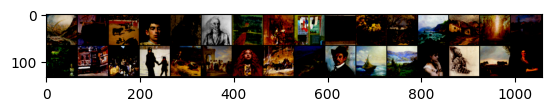

In [ ]:
## functions to show an image de Anel
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.clip(np.transpose(npimg, (1, 2, 0)), a_min=0, a_max=1))

## get some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images,nrow=16))
print(labels)

In [ ]:
#La técnica de visualización del artículo https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/
def show_images(images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=16).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

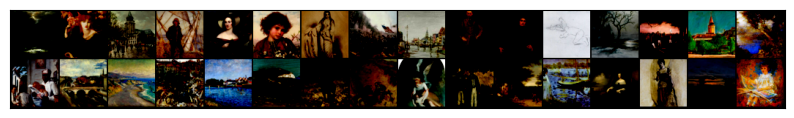

In [ ]:
show_batch(train_dl)

##Parámetros

In [ ]:
#Tamaño de una imagen sin transformar
imaux=Image.open('/content/artbench-10-split/train/impressionism/goldstein-grigoriy_morning.jpg')
np.array(imaux).shape

(256, 256, 3)

In [ ]:
#Tamaño de una imagen de dataloader
for x,_ in train_dl:
  print(x.shape) 
  break

torch.Size([32, 3, 64, 64])


In [ ]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100 #éste sí debe ser de 64 

#Modelo

Device y batch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

custom weights initialization called on generator and discriminator


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

##El Generador

In [ ]:
n_classes = 2 #Estaremos generando 10 estilos de pinturas, pero usaré los primeros 2 solo para entrenar
embedding_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()     
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))    
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512), #Estoy siguiendo esta guía para los parámetros https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
                                   nn.LeakyReLU(0.2, inplace=True))          

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),  #Aquí estaba el error, tenía 4,3,1
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 3, 4, 2, 1,bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1,512,4,4) 
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(2, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_siz

In [ ]:
#un ejemplo de cómo se ven los shapes al aplicar el generador
a_gen = torch.ones(100)
b_gen = torch.ones(1)
b_gen = b_gen.long()
a_gen = a_gen.to(device)
b_gen = b_gen.to(device)

In [ ]:
a_gen

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
b_gen

tensor([1])

In [ ]:
generator((a_gen,b_gen)).shape #Ya sale, el latent_dim debe ser de 64 para que pueda entrar al generador

torch.Size([1, 3, 64, 64])

##El Discriminador

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*64*64))
             
        self.model = nn.Sequential(
                      nn.Conv2d(6, 64*2, 4, 3, 2, bias=False),  ### Aquí se quitó una capa y se ajustaron las dimensiones
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )
        
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(2, 100)
    (1): Linear(in_features=100, out_features=12288, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.4, inplace=False)
    (10): Linear(in_features=4608, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [ ]:
a_disc = torch.ones(2,3,64,64)
b_disc = torch.ones(2,1)
b_disc = b_disc.long()
a_disc = a_disc.to(device)
b_disc = b_disc.to(device)

In [ ]:
a_disc

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        

In [ ]:
c = discriminator((a_disc,b_disc))
c.size()

torch.Size([2, 1])

## La pérdida

In [ ]:
adversarial_loss = nn.BCELoss() 

In [ ]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    print(disc_loss)
    return disc_loss

## Learning rate

In [ ]:
import torch.optim as optim


In [ ]:
learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

## Entrenamiento

In [ ]:
from torch.autograd import Variable


In [ ]:
import os
import errno
try:
    os.mkdir('/content/images')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
import os
import errno
try:
    os.mkdir('/content/training_weights/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
num_epochs = 1
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_dl,n_classes): #Intenté ejecutar y tronó la RAM, intentaré con menos imágenesn
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        #print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'torch/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

tensor(0.6948, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6878, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6778, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6781, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6400, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7683, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6270, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7878, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6032, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6158, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8093, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5606, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6028, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8267, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5035, grad_fn=<Bina

#CGAN del artículo (sin mi edición)

In [ ]:
#generated_image(generator, noise_vector)

In [ ]:
generator.load_state_dict(torch.load('torch/training_weights/generator_epoch_1.pth'), strict=False)
generator.eval()

In [ ]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)


pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])

interpolated = torch.tensor(interpolated)
interpolated = interpolated.to(device)
interpolated = interpolated.type(torch.float32)

output = None
for label in range(n_classes):
    labels = torch.ones(10) * label
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long()
    print(labels.size())
    predictions = generator((interpolated, labels))
    predictions = predictions.permute(0,2,3,1)
    pred = predictions.detach().cpu()
    if output is None:
        output = pred
    else:
        output = np.concatenate((output,pred))

torch.Size([10, 1])
torch.Size([10, 1])


In [ ]:
output.shape

(20, 64, 64, 3)

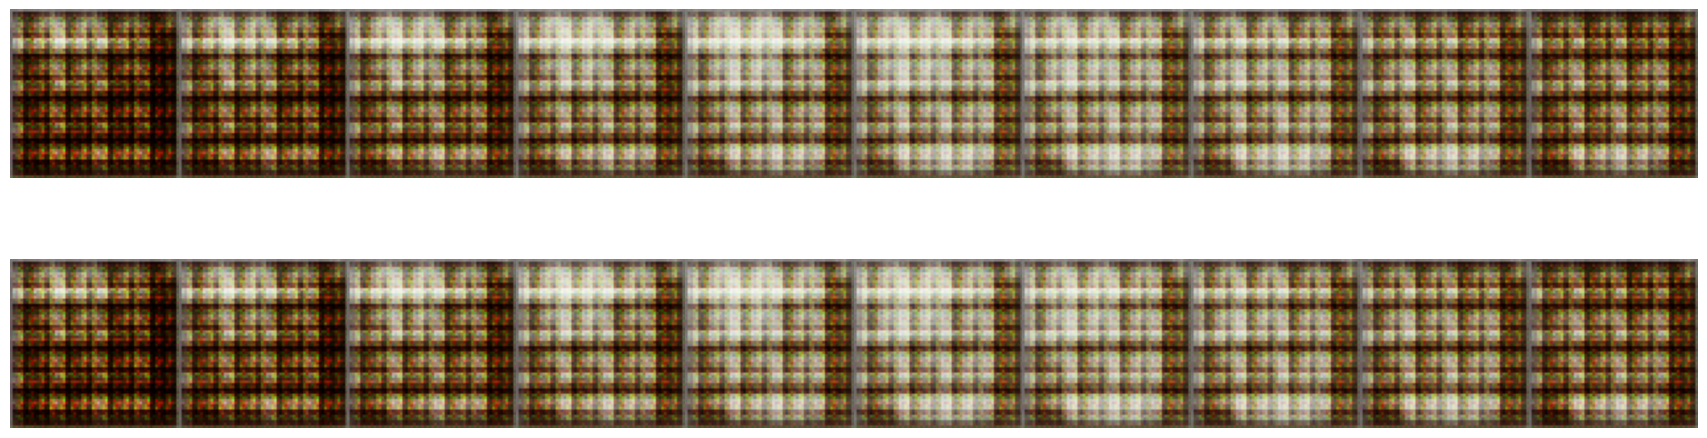

In [ ]:
nrow = n_classes
ncol = 10
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1,1, 1, 1, 1, 1],
     wspace=0.0, hspace=0.0, top=0.2, bottom=0.00, left=0.17, right=0.845) 

#output = output.reshape(-1, 128, 128, 3)
#print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
k = 0
for i in range(nrow):
    for j in range(ncol):
        pred = (output[k, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        ax= plt.subplot(gs[i,j])
        ax.imshow(pred.astype(np.uint8))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        k += 1   


#plt.savefig('result_torch.png',  dpi=300)
plt.show()

Referencia: GANs in Action: Deep Learning with Generative Adversarial Networks by Jakub Langr and Vladimir Bok.

https://github.com/spmallick/learnopencv/blob/master/Conditional-GAN-PyTorch-TensorFlow/PyTorch/CGAN-PyTorch.ipynb